

**Note**: Running this notebook as-is will not reproduce the same results as before, because the `wrangle()` function used for feature preparation was modified later.

This notebook was designed to help re-engineer or transform features based on insights drawn from modeling the residuals of the ensemble model.

Out-of-fold predictions were generated using the ensemble model, so the resulting residuals had the same size as `X_train`. Absolute residuals were computed, and samples with residuals above the 95th percentile were flagged as high-residual cases.

A Random Forest classifier was then trained to classify whether a sample belonged to this high-residual group or not. The idea was to see which features contributed most to large errors, so that they could be targeted for transformation or refinement.

The classification report (shown in the notebook) suggests that the model performs quite well in identifying low-residual cases. It struggles more with high-residual ones—probably due to the smaller proportion of such samples—but overall the model seems reliable. It gives a decent signal and isn't overfitting.

Feature importance from the classifier was then examined to understand which features were most related to high residuals. Insights were drawn from this, and some of these features were later transformed or re-engineered in the main pipeline.

This approach gave more direction to the feature engineering process and made it easier to focus on parts of the data that were actually driving model errors.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, StackingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns

from utils.data_prep import load_and_prepare_data
from utils.pipeline_create import create_pipeline

In [ ]:
data = load_and_prepare_data()

X_train = data['X_train']
y_train = data['y_train']
features = data['features']


In [ ]:
def drop_categorical_cols(X):
        cols = [f'meta_{i}' for i in range(4)] + list(X_train.columns)
        df_X = pd.DataFrame(X, columns=cols)
        return df_X.values

params = {'n_estimators': 148, 'learning_rate': 0.06135794647766489, 'max_depth': 5, 'subsample': 0.859463408443849, 'colsample_bytree': 0.6582116080444715, 'reg_alpha': 5.187729242130427, 'reg_lambda': 0.004853720820195554, 'min_child_weight': 2, 'gamma': 0.00868422759501035, 'booster': 'gbtree'}

meta_model = Pipeline(steps=
        [('drop_cat', FunctionTransformer(drop_categorical_cols, validate=False)),
        ('xgbregressor', XGBRegressor(**params))] 
    )

stack = StackingRegressor(
estimators=[
        ('ridge', create_pipeline('ridge', Ridge, {'alpha': 0.000261, 'solver': 'saga', 'fit_intercept': True, 'tol': 0.00045}, features)),
        ('extratrees', create_pipeline('extratrees', ExtraTreesRegressor, {'n_estimators': 263, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}, features)),
        ('catboost', create_pipeline('catboost', CatBoostRegressor, {'bootstrap_type': 'Bayesian', 'iterations': 488, 'learning_rate': 0.0632, 'depth': 9, 'l2_leaf_reg': 13.183, 'border_count': 97, 'random_strength': 0.821, 'grow_policy': 'Depthwise', 'bagging_temperature': 0.0695}, features)),
        ('lightgbm', create_pipeline('lightgbm', LGBMRegressor, {'max_depth': 10, 'num_leaves': 106, 'n_estimators': 421, 'learning_rate': 0.044, 'min_child_samples': 21, 'subsample': 0.753, 'colsample_bytree': 0.819, 'reg_alpha': 1.427, 'reg_lambda': 0.0363} , features)),
    ],
final_estimator=meta_model,  
passthrough=True,
cv=KFold(n_splits=5, shuffle=True, random_state=42),
n_jobs=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
residuals = np.zeros(X_train.shape[0])

for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        stack_clone = clone(stack)
        stack_clone.fit(X_tr, y_tr)

        preds = stack_clone.predict(X_val)
        oof_preds[val_index] = preds
        residuals[val_index] = y_val - preds

df_resid = X_train.copy()
df_resid['target'] = y_train
df_resid['oof_preds'] = oof_preds
df_resid['residuals'] = residuals   
df_resid['abs_residuals'] = np.abs(residuals)
print("training done")

In [ ]:
threshold = np.percentile(df_resid['abs_residuals'], 95)
df_resid['is_high'] = (df_resid['abs_residuals'] > threshold).astype(int)

X = df_resid.drop(columns = ['target', 'oof_preds', 'residuals', 'abs_residuals', 'is_high', 'gender'])
y = df_resid['is_high']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val) 

report = classification_report(y_val, y_pred)
print(report)

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.96      | 0.99   | 0.97     | 130321  |
| 1     | 0.54      | 0.19   | 0.28     | 6859    |
| **Accuracy** |       |        | **0.95** | **137180** |
| **Macro avg** | 0.75  | 0.59   | 0.63     | 137180  |
| **Weighted avg** | 0.94 | 0.95   | 0.94     | 137180  |

In [ ]:
importance = pd.Series(clf.feature_importances_, index = X.columns)
importance.sort_values(ascending=False, inplace=True)
importance

| Feature                  | Importance |
|--------------------------|------------|
| age_cardio_load          | 0.1041     |
| row_mean                 | 0.0801     |
| row_std                  | 0.0796     |
| bmi_hr_product           | 0.0742     |
| bmi                      | 0.0661     |
| weight_duration_ratio    | 0.0658     |
| temp_hr_ratio            | 0.0640     |
| age                      | 0.0574     |
| temp_duration_product    | 0.0532     |
| cardio_load              | 0.0487     |
| height                   | 0.0480     |
| weight                   | 0.0469     |
| hr_per_minute            | 0.0380     |
| body_temp                | 0.0355     |
| temp_deviation           | 0.0339     |
| heart_rate               | 0.0327     |
| heart_rate_squared       | 0.0320     |
| duration                 | 0.0220     |
| sex_female               | 0.0090     |
| sex_male                 | 0.0090     |

The distribution of the most influencing features were checked, and transformations were made based on the figures. The reason behind these transformations was that if the histogram distribution is messy or skewed, sometimes the model may not be able to interpret these features well, so some transformations were made in order to cope with that.

If histogram is skewed (tail stretched) → log1p  
If histogram is bell-shaped, symmetric → z-score  
If histogram is messy, spiky, or irregular → binning (e.g., pd.qcut or pd.cut)  

KDE is helpful to confirm shape, but histogram is more reliable when KDE is noisy.


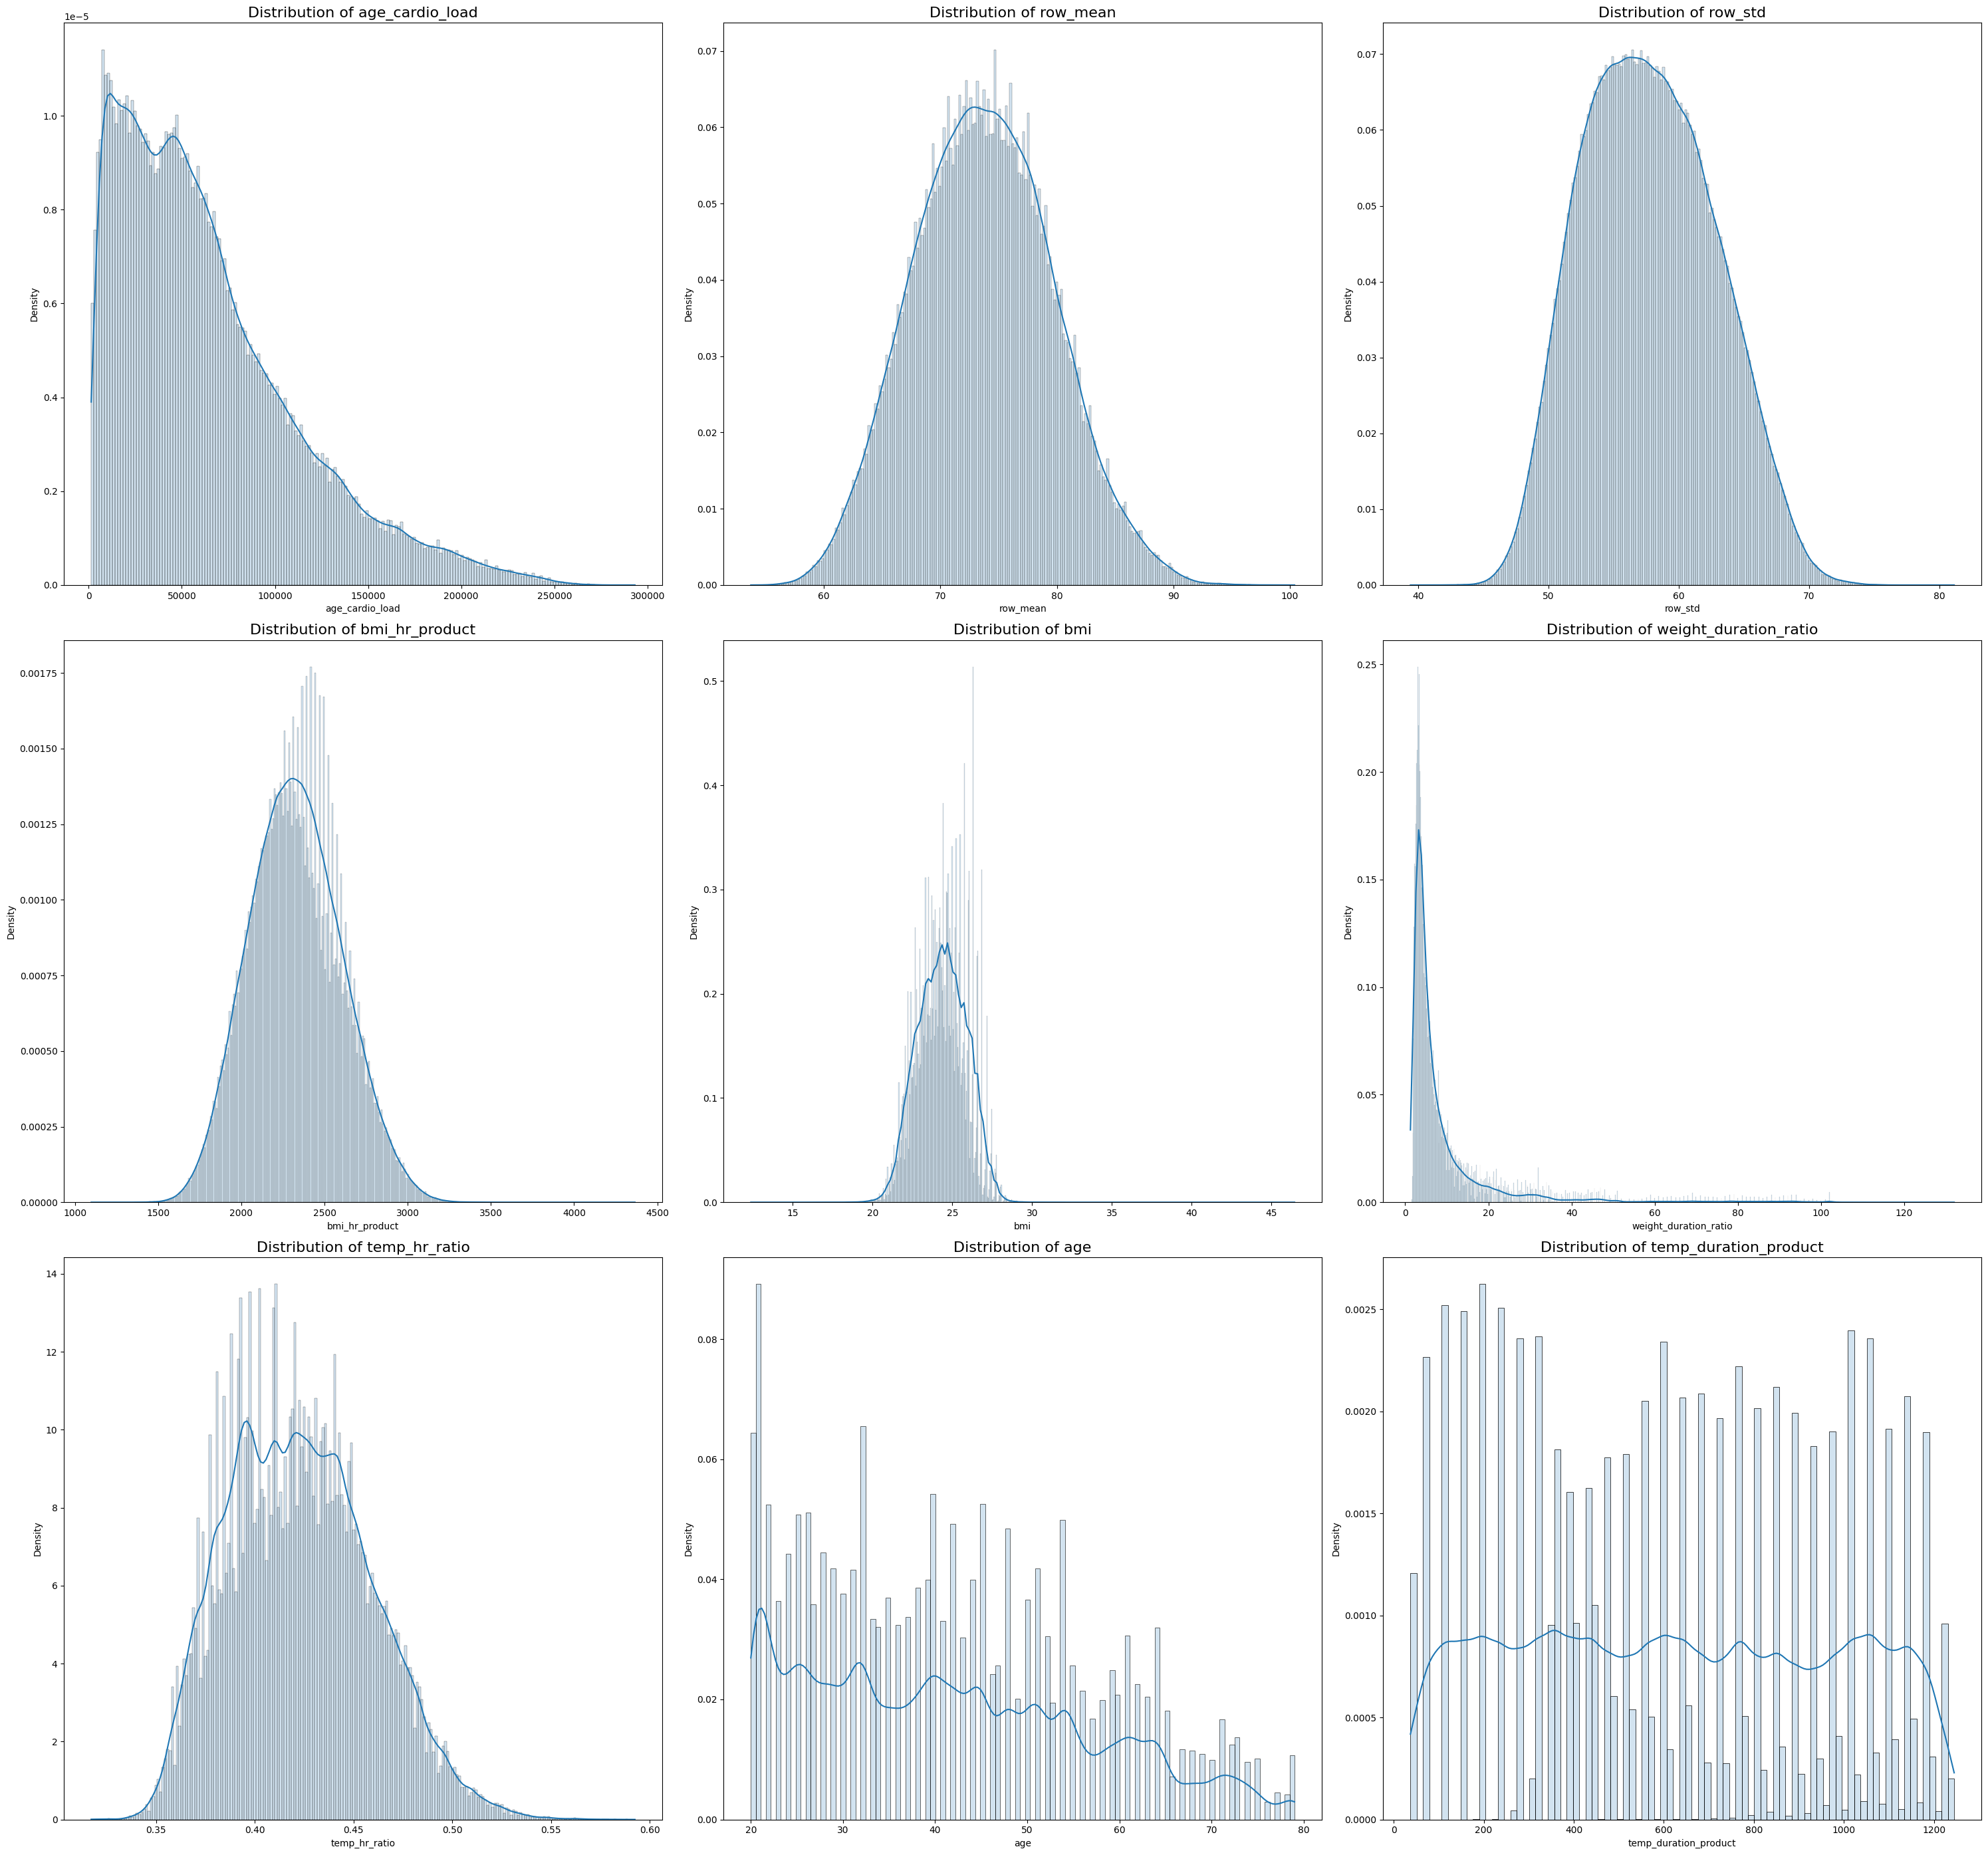

In [4]:
fig, ax = plt.subplots(figsize=(30, 28), nrows=3, ncols=3)
ax = ax.flatten()
cols = ['age_cardio_load', 'row_mean', 'row_std', 'bmi_hr_product', 'bmi',
        'weight_duration_ratio', 'temp_hr_ratio', 'age', 'temp_duration_product']

for i, col in enumerate(cols):  # loop directly over column names
    sns.histplot(X_train[col], stat='density', kde=True, alpha=0.2, ax=ax[i])
    ax[i].set_title(f'Distribution of {col}', fontsize=16)

plt.tight_layout()
plt.show()

New features were engineered based on this, and both the transformed features and the new features were kept to see the model performance.

The engineered features:  
`log_age_cardio_load`, `log_weight_duration_ratio`, `temp_duration_product_bin`, `age_bin`, `z_row_mean`, `z_row_std`, `z_bmi_hr_product`, `z_bmi`


When the models were trained again with these newly engineered features, the result was confusing. While Ridge and CatBoost showed better cross-validation scores (RMSE here), the other models were not performing really well. So, the `ModelEvaluator` was applied on these models to see the performance of each model in different segments and how they handle features.

It was seen that the z-score features were not at all influencing the tree-based models, and binning some features was also giving a lower score compared to the original feature itself (probably because tree models can handle splits themselves). But the linear model was performing really well after this.

So, some features were removed or were assigned selectively to different models for their performance evaluation. This can be seen in `data_prep.py` (drop for linear models, drop for other models), and model performance increased.